# Date Preprocessing for EWMA Matlab

In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm
import matplotlib.mlab as mlab

In [2]:
# data from 2017.1.1 to 2021.3.28
btc = pd.read_csv('data/BTC-USD.csv')
eth = pd.read_csv('data/ETH-USD.csv')
xrp = pd.read_csv('data/XRP-USD.csv')

In [3]:
# only using adj close data
btc_price = btc['Adj Close'].to_numpy()
eth_price = eth['Adj Close'].to_numpy()
xrp_price = xrp['Adj Close'].to_numpy()

In [4]:
date_array = btc['Date'].to_numpy()

In [5]:
price_dataset = pd.DataFrame({'Date': date_array, 'btc': btc_price, 'eth': eth_price, 'xrp': xrp_price})

In [6]:
# convert price to returns and adjust length
# e.g. 1.1 $100, 1.2 : $120, return: 1.2 with ln(120) - ln(100)
# u(i) = ln(s(i)/s(i-1))
return_btc = np.diff(np.log(price_dataset.btc), n=1, axis=0)
return_eth = np.diff(np.log(price_dataset.eth), n=1, axis=0)
return_xrp = np.diff(np.log(price_dataset.xrp), n=1, axis=0)

In [7]:
return_dataset = pd.DataFrame({'Date': price_dataset.Date.to_numpy()[1:], 'btc': return_btc, 'eth': return_eth, 'xrp': return_xrp})

In [8]:
return_dataset.isnull().values.any()

True

In [9]:
return_dataset = return_dataset.dropna()

In [10]:
len(return_dataset) 

1540

In [13]:
return_dataset.to_csv('returns.csv', index=False)  

In [14]:
return_data_2018 = return_dataset.iloc[363:]

In [15]:
return_dataset.to_csv('returns_2018.csv', index=False)  

In [17]:
return_data_2018.head()

,Date,btc,eth,xrp
363,2018-01-01,-0.035900,0.020804,0.038567
364,2018-01-02,0.092589,0.135145,0.036897
365,2018-01-03,0.014505,0.084803,0.224511
366,2018-01-04,0.025858,0.018730,0.028964
367,2018-01-05,0.110945,0.016980,-0.047379


# Plot distributions

In [18]:
crptocurrencies = ['btc','eth','xrp']
weights = np.array([1/3,1/3,1/3]) # assume equal weightage
bins_num = 100

# var-cov matrix
cov_matrix = return_data_2018.cov()
# Calculate mean returns for each stock
avg_rets = return_data_2018.mean()
port_mean = avg_rets.dot(weights)
# Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

C:\Users\USER\Anaconda3\lib\site-packages\pandas\plotting\_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


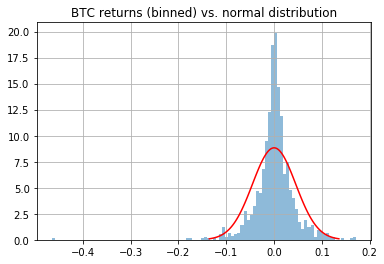

In [19]:
# Repeat for each equity in portfolio
return_data_2018['btc'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("BTC returns (binned) vs. normal distribution")
plt.show()

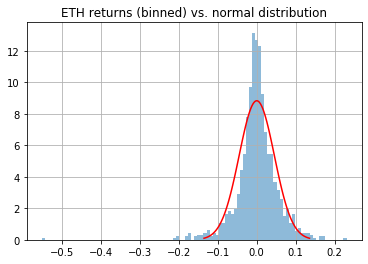

In [20]:
# Repeat for each equity in portfolio
return_data_2018['eth'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("ETH returns (binned) vs. normal distribution")
plt.show()

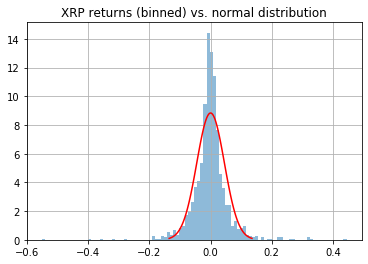

In [21]:
# Repeat for each equity in portfolio
return_data_2018['xrp'].hist(bins=bins_num, normed=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("XRP returns (binned) vs. normal distribution")
plt.show()

# Portfolio EWMA Calculation

In [24]:
y = return_data_2018[['btc','eth','xrp']].to_numpy()
T = len(return_data_2018)
EWMA = np.full([T,3], np.nan)
VAR = np.full([T,3], np.nan)
COV = np.full([T,3], np.nan)
lmbda = 0.94
S = np.cov(y, rowvar = False)
# EWMA[0,] = S.flatten()[[0,3,1]]
VAR[0,] = [S[0,0],S[1,1],S[2,2]]
COV[0,] = [S[0,1],S[0,2],S[1,2]]

In [51]:
y[0]

array([-0.03589998,  0.02080406,  0.03856732])

In [49]:
S

matrix([[0.00142388, 0.00130615, 0.00085098],
        [0.00130615, 0.00176551, 0.00118512],
        [0.00085098, 0.00118512, 0.00398868]])

In [26]:
crptocurrencies = ['btc','eth','xrp']
# var-cov matrix
cov_matrix = return_data_2018.cov()
# Calculate mean returns for each stock
avg_rets = return_data_2018.mean()
# w_... : weight_...
# v_... : var...
# cov12 : covariance(1,2)
def portfolio_daily_var(w1,w2,w3,v1,v2,v3,cov12,cov13,cov23):
    return (w1**2)*v1 + (w2**2)*v2 + (w3**2)*v3 \
        + 2*w1*w2*cov12 + 2*w1*w3*cov13 + 2*w2*w3*cov23 

In [36]:
cov_matrix

,btc,eth,xrp
btc,0.001637,0.001724,0.001448
eth,0.001724,0.002668,0.002069
xrp,0.001448,0.002069,0.003564


In [56]:
# var = cov when it is S[0,0] S[1,1] S[2,2]
for i in range(1,T):
    S = lmbda * S + (1-lmbda) * np.transpose(np.asmatrix(y[i-1]))* np.asmatrix(y[i-1])
#     EWMA[i,] = [S[0,0], S[1,1], S[0,1]] # self.cov.btc.sigma, self.cov.eth.sigma, cov.btc.eth?
    VAR[i,] = [S[0,0],S[1,1],S[2,2]] # var_btc,var_eth,var_xrp
    COV[i,] = [S[0,1],S[0,2],S[1,2]] # cov12,cov13,cov23
# EWMArho = np.divide(EWMA[:,2], np.sqrt(np.multiply(EWMA[:,0],EWMA[:,1])))
# print(EWMArho)

In [57]:
VAR

array([[0.00163742, 0.00266763, 0.00356351],
       [0.00140816, 0.00161039, 0.00369754],
       [0.00183803, 0.00260961, 0.00355737],
       ...,
       [0.00159698, 0.00197924, 0.00445768],
       [0.00151475, 0.00186431, 0.00424326],
       [0.00142388, 0.00176551, 0.00398868]])

In [58]:
COV #btc_eth, btc_xrp, eth_xrp

array([[0.00172423, 0.00144809, 0.00206863],
       [0.00106718, 0.00059076, 0.00114057],
       [0.00175393, 0.0007603 , 0.00137132],
       ...,
       [0.00147014, 0.00099167, 0.00135697],
       [0.00138914, 0.00090531, 0.00126131],
       [0.00130615, 0.00085098, 0.00118512]])

# User inputs

In [60]:
btc_value = 3000
eth_value = 3200
xrp_value = 4800
total_investment = btc_value + eth_value + xrp_value
if (total_investment == 0): total_investment = 0.0000000000001
w_btc = btc_value/total_investment
w_eth = eth_value/total_investment
w_xrp = xrp_value/total_investment

In [62]:
weights = np.array([w_btc,w_eth,w_xrp]) # assume equal weightage
portfolioVariance = np.zeros(T)
for i in range(0,T):
    portfolioVariance[i] = portfolio_daily_var(w_btc,w_eth,w_xrp,
                                 VAR[i,0],VAR[i,1],VAR[i,2],
                                 COV[i,0],COV[i,1],COV[i,2])

In [63]:
EWMA95 = np.zeros(T)

In [64]:
crptocurrencies = ['btc','eth','xrp']
# # var-cov matrix
# cov_matrix = return_data_2018.cov()
# Calculate mean returns for each stock
avg_rets = return_data_2018.mean()

In [65]:
-norm.ppf(0.05)

1.6448536269514729

In [73]:
math.sqrt(portfolioVariance[1])

0.039301472967947955

In [77]:
import math
pVar = 0.05
Zscore = norm.ppf(pVar)
EWMA95[0] = portfolioVariance[0]

for t in range(1,len(return_data_2018)):
    Sigma = math.sqrt(portfolioVariance[t])
    EWMA95[t] = -Zscore*Sigma

In [80]:
# new-day var in dollars
new_day_var = total_investment * EWMA95[-1]

751.5856334214026

In [ ]:
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(new_day_var * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")
plt.show()


# 1-Day Var

In [ ]:
# Calculate mean of investment
mean_investment = (1+port_mean) * total_investment
             
# Calculate standard deviation of investmnet
stdev_investment = total_investment * port_stdev
# Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
var_1d1 = initial_investment - cutoff1
# Calculate n Day VaR




# Identify distributions

In [48]:
dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
def print_chi_square_stats_distributions(y_std,size):
    chi_square_statistics = []
    # 11 equi-distant bins of observed Data 
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions
    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))


        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [54]:
btc_arr = price_data_2018.btc.to_numpy().reshape(-1,1)
eth_arr = price_data_2018.eth.to_numpy().reshape(-1,1)
xrp_arr = price_data_2018.xrp.to_numpy().reshape(-1,1)

In [55]:
scaler = preprocessing.StandardScaler().fit(btc_arr)
btc_arr_scaled = scaler.transform(btc_arr)

In [56]:
scaler = preprocessing.StandardScaler().fit(eth_arr)
eth_arr_scaled = scaler.transform(eth_arr)

In [57]:
scaler = preprocessing.StandardScaler().fit(xrp_arr)
xrp_arr_scaled = scaler.transform(xrp_arr)

In [62]:
size = len(btc_arr)

In [63]:
# print btc_return
print_chi_square_stats_distributions(btc_arr_scaled,size)

(0.9781049742072642, -0.7780388402789964, 0.7723930855159418)

(0.0, 0.9999999999999999)

(0.5930308587163668, 4.751592981033981, 1.448598238442428)

(1.0619305065947056, 664008424.5583026, -0.7780932479887603, 491649392.60081875)

(0.921791310449886, -0.872501553536958, 0.9465101013040453)

(-0.7780388402789963, 5.529631821312976)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.5295040588187883, -0.7780388402789964, 1.1586159592429226)

(-0.7780388402789963, 0.7780388402789963)

(0.8627630944472638, -0.8347469316352922, 0.555234967892748)

(1.9230838630986198, -0.0010997376559197774, 0.7471351959542738)

(1.3263335616598192e-08, -0.7780390334595146, 6.732842401605389)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
8       lognorm   150.542261
4      invgauss   163.214734
9      pearson3   169.862634
3          beta   174.405811
7         expon   189.440142
0   weibull_min   201.624072
6         gamma  1297.218960
1          norm  1978.685490
10       triang  2464.371215
5       uniform  3336.785581
2   weibull_max  4965.477527


In [64]:
# print eth price distribution results
print_chi_square_stats_distributions(eth_arr_scaled,size)

(0.9399739481919274, -0.8354562901157037, 0.801498249092706)

(-3.612929164881865e-17, 1.0)

(421190428.80981845, 221987282.63230023, 221987283.00994805)

(0.47601706786980513, 1.5654959643349544, -0.8354562901157037, 4.889577290682638)

(1.5037358926384146, -0.8739483399928676, 0.5811926827725389)

(-0.8354562901157035, 4.747671310404048)

(0.9804524567466459, -0.8354562901157037, 0.8514478897551476)

(-0.8354562901157035, 0.8354562901157035)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


(1.0521065779459193, -0.8469697715193445, 0.48798755131279103)

(2.0114074254416936, -6.003707162899456e-17, 0.840221492785348)

(0.015808821962417875, -0.8546309186645406, 4.780828025456559)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
4      invgauss    20.858483
8       lognorm    26.092515
0   weibull_min   106.902636
6         gamma   109.931982
9      pearson3   110.805439
7         expon   111.887397
3          beta   400.532134
2   weibull_max   673.853835
10       triang  1565.784069
1          norm  1791.816026
5       uniform  2770.435225


In [65]:
# print xrp price distribution results
print_chi_square_stats_distributions(xrp_arr_scaled,size)

(1.1116814054737825, -0.85098351432558, 0.891285770572388)

(0.0, 1.0)

(79697203.12610704, 36242753.45836888, 36242753.77812006)

(1.4185066157389983, 327765.3096070803, -0.8515749180171195, 197725.0183963137)

(0.7831054348770745, -0.9128603133154567, 1.1656931891896454)

(-0.8508765933277969, 10.102187435594672)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.5090449228542359, -0.850876593327797, 2.6823966512933923)

(-0.8508765933277969, 0.8508765933277969)

(0.7988121718014496, -0.8809660835544455, 0.6220646400978505)

(1.667794284127956, -0.0026768018293471876, 0.7079064989078749)

(0.007454507883768183, -0.8709319010459381, 10.132183689884318)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
8       lognorm    13.702973
4      invgauss    19.754927
9      pearson3    64.863059
3          beta    68.585848
0   weibull_min   117.577148
2   weibull_max   222.492448
7         expon   227.159400
6         gamma   733.464417
1          norm  1506.459619
10       triang  2950.798065
5       uniform  3946.237552


In [49]:
size = len(return_data_2018)
# print btc_return
print_chi_square_stats_distributions(return_data_2018.btc,size)

(13.018370578393842, -0.5309098529890504, 0.5498652682531413)

(0.0012229515943203697, 0.04041372912514586)

(3.727437980676617, 0.17434469415669912, 0.18785415024769148)

(123046.0079604651, 113.81484264236494, -460.8256433333704, 461.25311213111667)

(0.002884321033656912, -0.8510874701609674, 294.50266851720164)

(-0.46473017535485006, 0.6365507372548098)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(97.28579313921773, -0.5260517241955309, 0.005397057791070945)

(-0.46473017535485006, 0.4659531269491704)

(0.0010871468458359323, -37.15062539161261, 37.1518180021088)

(-0.17279156130612927, 0.0012218098296584655, 0.039842951120708694)

(0.7587816433770023, -0.4653111232467266, 0.6380584226947015)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
9      pearson3   136.690426
3          beta   137.541994
8       lognorm   157.246092
1          norm   157.259324
0   weibull_min   301.754575
2   weibull_max   321.017906
4      invgauss   372.540219
6         gamma   532.965724
7         expon  4722.367228
10       triang  4828.369431
5       uniform  6405.716312


In [50]:
# print eth
print_chi_square_stats_distributions(return_data_2018.eth,size)

(12.692771497210238, -0.6361551749422003, 0.659326922481474)

(0.0007265514408880328, 0.05165905058978368)

(3.9604743049484794, 0.23346382439953117, 0.25220251374959)

(4872688.415120546, 66.87534084691994, -30568.012963216435, 30568.433186303686)

(0.004398480872320098, -0.9166055643451392, 208.1133816415835)

(-0.5507317441312178, 0.7814269728784762)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(408.52620405754794, -1.2508909047847054, 0.0030624411826513835)

(-0.5507317441312178, 0.5514582955721059)

(0.0009525819291085098, -54.198455590204986, 54.199275988006434)

(-0.20911195818133343, 0.0010828769939270956, 0.05084583707904698)

(0.7329663592973623, -0.5514492227838977, 0.7830246246556986)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
9      pearson3   101.455677
3          beta   109.238831
8       lognorm   123.633336
1          norm   125.569806
0   weibull_min   228.738809
2   weibull_max   289.639651
6         gamma   304.053169
4      invgauss   334.710423
10       triang  4179.814078
7         expon  4664.208470
5       uniform  5693.639516


In [51]:
# print xrp
print_chi_square_stats_distributions(return_data_2018.xrp,size)

(7.839572695358168, -0.5729151078605048, 0.5975243080888626)

(-0.0012193258983714576, 0.05961774792889459)

(6.088587920794138, 0.455514391225274, 0.48143792684420017)

(18382.337026364465, 17135.048211069334, -11.644452477918392, 22.496442472519124)

(0.003564268449483699, -1.0805818965731397, 302.6532187298867)

(-0.5505025324881687, 0.9952581356702372)

(299.3116717060176, -1.0945638688931165, 0.0036484928002480854)

(-0.5505025324881687, 0.5492832065897972)



C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.0021559932066416414, -27.654662088578437, 27.653506250484327)

(-0.019622400760228732, -0.0012259807703472003, 0.05959849886970018)

(0.5559270029430192, -0.5514214854084218, 0.99711600860044)


Distributions listed by Betterment of fit:
............................................
   Distribution   chi_square
9      pearson3   242.889562
8       lognorm   243.268528
1          norm   244.714002
3          beta   245.119962
6         gamma   340.041967
4      invgauss   354.706550
2   weibull_max   545.481041
0   weibull_min   713.672036
10       triang  2296.989027
5       uniform  2967.272022
7         expon  4606.356411


In [ ]:
# from arch.univariate import EWMAVariance
# rm = EWMAVariance(0.94)

# Garch 1,1 Model

In [67]:
import numpy as np
import scipy
import pandas as pd
class garchOneOne(object):
       
    def __init__(self, logReturns):
        self.logReturns = logReturns
        self.sigma_2 = self.garch_filter(self.garch_optimization())
        self.coefficients = self.garch_optimization()
        
    def garch_filter(self, parameters):
        "Returns the variance expression of a GARCH(1,1) process."
        
        # Slicing the parameters list
        omega = parameters[0]
        alpha = parameters[1]
        beta = parameters[2]
        
        # Length of logReturns
        length = len(self.logReturns)
        
        # Initializing an empty array
        sigma_2 = np.zeros(length)
        
        # Filling the array, if i == 0 then uses the long term variance.
        for i in range(length):
            if i == 0:
                sigma_2[i] = omega / (1 - alpha - beta)
            else:
                sigma_2[i] = omega + alpha * self.logReturns[i-1]**2 + beta * sigma_2[i-1]
        
        return sigma_2 
        
    def garch_loglikehihood(self, parameters):
        "Defines the log likelihood sum to be optimized given the parameters."
        length = len(self.logReturns)
        
        sigma_2 = self.garch_filter(parameters)
        
        loglikelihood = - np.sum(-np.log(sigma_2) - self.logReturns**2 / sigma_2)
        return loglikelihood
    
    def garch_optimization(self):
        "Optimizes the log likelihood function and returns estimated coefficients"
        # Parameters initialization
        parameters = [.1, .05, .92]
        
        # Parameters optimization, scipy does not have a maximize function, so we minimize the opposite of the equation described earlier
        opt = scipy.optimize.minimize(self.garch_loglikehihood, parameters,
                                     bounds = ((.001,1),(.001,1),(.001,1)))
        
        variance = .01**2 * opt.x[0] / (1 - opt.x[1] - opt.x[2])   # Times .01**2 because it concerns squared returns
        
        return np.append(opt.x, variance)

In [132]:
def run_garch(data,cryptoType, conf_interval, dist_type):
    print("="*40)
    print("="*40)
    print ("Running Garch 1,1 model for %s" %cryptoType)
    model = garchOneOne(data)
    arch_m = arch_model(data, mean = 'Zero', vol = 'GARCH', dist = dist_type)
    arch_m = arch_m.fit()
    conf_int = pd.DataFrame(arch_m.conf_int(alpha = conf_interval))
#     conf_int['garchOneOne'] = model.coefficients[:-1]
#     conf_int['Test'] = np.where(conf_int['garchOneOne'] < conf_int['upper'], np.where(conf_int['garchOneOne'] > conf_int['lower'], "Ok", "Not ok"), "Not ok") 
#     print("conf_int for %s" %cryptoType)
#     print(conf_int)
    
    %matplotlib inline
#     df = pd.DataFrame(np.sqrt(model.sigma_2))
#     print(df.head())
#     # Plotting the data
#     plt.plot(df, label = ' GARCH(1,1)', linewidth = .75)
#     plt.legend()
#     plt.title('GARCH(1,1) processes of %s' %cryptoType, fontweight = 'bold')
#     return model.sigma_2
    return np.sqrt(model.sigma_2)

In [127]:
return_data_2018 = return_dataset.iloc[364:]

In [143]:
return_data_2018.head()

,Date,btc,eth,xrp
364,2018-01-01,0.092589,0.135145,0.036897
365,2018-01-02,0.014505,0.084803,0.224511
366,2018-01-03,0.025858,0.018730,0.028964
367,2018-01-04,0.110945,0.016980,-0.047379
368,2018-01-05,0.005578,0.043117,0.014737


In [150]:
from scipy.stats import anderson
# normality test
result = anderson(return_data_2018.btc)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 26.226
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)


In [146]:
# normality test
stat, p = shapiro(return_data_2018.eth)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.914, p=0.000
Sample does not look Gaussian (reject H0)


In [147]:
# normality test
stat, p = shapiro(return_data_2018.xrp)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.834, p=0.000
Sample does not look Gaussian (reject H0)


In [ ]:
from scipy.stats import norm

In [137]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'normal')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'normal')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'normal')
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_csv('gammas_normal.csv', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: 212062.57624308104
Iteration:      2,   Func. Count:     12,   Neg. LLF: -2042.565016635665
Iteration:      3,   Func. Count:     19,   Neg. LLF: -1304.1690958768052
Iteration:      4,   Func. Count:     24,   Neg. LLF: -2111.2789591208416
Iteration:      5,   Func. Count:     29,   Neg. LLF: -2103.9755313467704
Iteration:      6,   Func. Count:     34,   Neg. LLF: -2115.066514432211
Iteration:      7,   Func. Count:     39,   Neg. LLF: -2163.8469654459045
Iteration:      8,   Func. Count:     43,   Neg. LLF: -2163.8754078053375
Iteration:      9,   Func. Count:     47,   Neg. LLF: -2163.8761512667265
Iteration:     10,   Func. Count:     51,   Neg. LLF: -2163.876148174865
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2163.8761514974562
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
Running Garch 1,1 mod

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2299.1221229241587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3068230.7977573248
Iteration:      3,   Func. Count:     18,   Neg. LLF: -1786.9805005850721
Iteration:      4,   Func. Count:     23,   Neg. LLF: -1831.2604752380653
Iteration:      5,   Func. Count:     29,   Neg. LLF: -1831.2362125422965
Iteration:      6,   Func. Count:     34,   Neg. LLF: -1860.7222497112175
Iteration:      7,   Func. Count:     39,   Neg. LLF: -1860.7731143973897
Iteration:      8,   Func. Count:     43,   Neg. LLF: -1860.773130383919
Iteration:      9,   Func. Count:     46,   Neg. LLF: -1860.7731303837916
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1860.773130383919
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1830.7208143146865
Optimization terminated

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [140]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'studentst')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'studentst')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'studentst')
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_studentt.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: -2320.6050656523958
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2320.605065866496
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1977.2479809660442
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1977.2479810976913
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      6,   Neg. LLF: 14202.38763689252
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1578.0979833801707
Iteration:      3,   Func. Count:     20,   Neg. LLF: -921.1561372126803
Iteration:      4,   Func. Count:     26,   Neg. LLF: -1071.7996623242047
Iteration:      5,   Func. Count:     32,   Neg. LLF: 673.3230982086244
Iteration:      6,   Func. Count:     41,   Neg. LLF: -1910.6770849384413
Iteration:      7,   Func. Count:     47,   Neg. LLF: -1304.9013812637888
Iteration:      8,   Func. Count:     53,   Neg. LLF: -2028.0516842832913
Iteration:      9,   Func. Count:     58,   Neg. LLF: -2029.7873672056598
Iteration:     10,   Func

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [141]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'skewt')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'skewt')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'skewt')
var_btc = np.abs(-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_skewt.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      6,   Neg. LLF: -2320.6050651179103
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2320.605065866496
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1977.2479806076685
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1977.2479810976913
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      7,   Neg. LLF: 40367.61186267997
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5198.870475077545
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1346.3312481354465
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1733.4603608714128
Iteration:      5,   Func. Count:     40,   Neg. LLF: -1716.9568867619496
Iteration:      6,   Func. Count:     47,   Neg. LLF: -990.6410231829343
Iteration:      7,   Func. Count:     54,   Neg. LLF: -1396.6179127003707
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1317.409726265208
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1928.3368871605696
Iteration:     10,   Func. 

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


In [142]:
btc_sigma = run_garch(return_data_2018.btc.to_numpy(), "BTC", 0.05,'ged')
eth_sigma = run_garch(return_data_2018.eth.to_numpy(), "ETH", 0.05,'ged')
xrp_sigma = run_garch(return_data_2018.xrp.to_numpy(), "XRP", 0.05,'ged')
var_btc = np.abs(return_data_2018.btc.to_numpy()-norm.ppf(0.05)*btc_sigma)
var_eth = np.abs(return_data_2018.eth.to_numpy()-norm.ppf(0.05)*eth_sigma)
var_xrp = np.abs(return_data_2018.xrp.to_numpy()-norm.ppf(0.05)*xrp_sigma)
gamma_vol_95 = pd.DataFrame({'btc': return_data_2018.btc, 'var_95_btc': var_btc,
              'eth': return_data_2018.eth, 'var_95_eth': var_eth,
              'xrp': return_data_2018.xrp, 'var_95_xrp': var_xrp})
gamma_vol_95.to_excel('gammas_ged.xlsx', index=False)  

Running Garch 1,1 model for BTC
Iteration:      1,   Func. Count:      5,   Neg. LLF: -2267.711835497006
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2267.7118381040423
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for ETH


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001636. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This wa

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1941.0786464264697
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1941.078648393754
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Running Garch 1,1 model for XRP
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1250388.3993422482
Iteration:      2,   Func. Count:     12,   Neg. LLF: -1514.4443820773272
Iteration:      3,   Func. Count:     18,   Neg. LLF: -1726.2637400919775
Iteration:      4,   Func. Count:     24,   Neg. LLF: 2055.808650241822
Iteration:      5,   Func. Count:     33,   Neg. LLF: -1928.031192561968
Iteration:      6,   Func. Count:     39,   Neg. LLF: -1993.5466140111596
Iteration:      7,   Func. Count:     44,   Neg. LLF: -1850.933292015438
Iteration:      8,   Func. Count:     51,   Neg. LLF: -1995.0361170716074
Iteration:      9,   Func. Count:     58,   Neg. LLF: -1994.1543445637851
Iteration:     10,   Func.

C:\Users\USER\AppData\Roaming\Python\Python37\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003562. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


# Monte Carlo

In [99]:
ewma_data = pd.read_csv('ewma.csv', header=None)
gammas_data = pd.read_csv('gammas.csv')
monte_carlo_data = pd.read_csv('monte_carlo.csv', header=None)

In [100]:
ewma_data.head()

,0,1,2,3,4,5
0,0.092589,0.21671,0.135140,0.24658,0.036897,0.32253
1,0.014505,0.14050,0.084803,0.20579,0.224510,0.50184
2,0.025858,0.14815,0.018730,0.14091,0.028964,0.31266
3,0.110940,0.22997,0.016980,0.13568,-0.047379,0.22792
4,0.005578,0.12933,0.043117,0.15840,0.014737,0.28233


In [101]:
len(return_data_2018.Date.to_numpy())

1176

In [102]:
len(ewma_data[1])

1176

In [105]:
gammas_data.head()

,btc,var_95_btc,eth,var_95_eth,xrp,var_95_xrp
0,0.092589,0.095197,0.135145,0.139901,0.036897,0.101614
1,0.014505,0.017440,0.084803,0.092767,0.224511,0.245682
2,0.025858,0.028513,0.018730,0.026075,0.028964,0.094273
3,0.110945,0.113525,0.016980,0.022571,-0.047379,0.026643
4,0.005578,0.008679,0.043117,0.047771,0.014737,0.024711


In [106]:
len(gammas_data['var_95_btc'])

1176

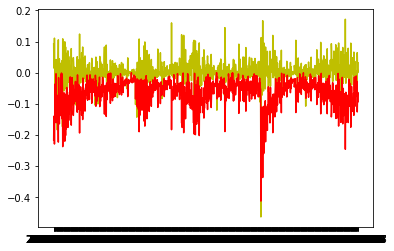

In [113]:
import matplotlib.pyplot as plt
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-ewma_data[1],'r')
plt.show()

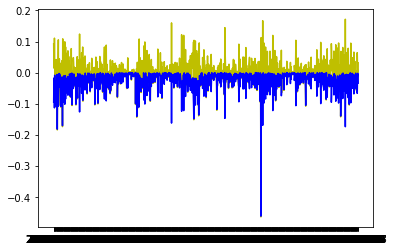

In [114]:
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-gammas_data['var_95_btc'],'b')
plt.show()

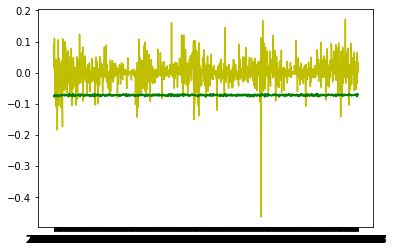

In [115]:
plt.plot(return_data_2018.Date.to_numpy(),ewma_data[0],'y')
plt.plot(return_data_2018.Date.to_numpy(),-monte_carlo_data[1],'g')
plt.show()